<a href="https://colab.research.google.com/github/Polijav/ia4business/blob/master/T202412_LongTermMemoryAIAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Long-Term Memory AI Assistent for Content Creation
In this notebook, we will use the LangGraph Framework to develop an AI Assisant that will help us manage our content creation calendar.

This AI Agent will be capable to remember information about:
- the user: preferences
- the content calendar: multiple content items with information regarding platform, deadline, etc.
- the writing style guideline


This notebook was based on a tutorial provided by LangChain Academy: https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-5/memory_agent.ipynb

In [ ]:
! pip install trustcall langchain_core langchain_openai langgraph

In [ ]:
import uuid
import os
from typing import Literal
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field
from typing import TypedDict, Literal

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import ChatOpenAI

from google.colab import userdata

In [ ]:
# Load from google secrets
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Set variables for LangSmith Tracking
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Memory Management
Effective memory management is the backbone of the AI agent's ability to store and recall information, adapt to user inputs, and provide a seamless experience. To achieve this, the agent uses structured schemas defined with Pydantic, ensuring consistency, validation, and scalability.

In this tutorial, the AI agent relies on three key memory components:
- the User Profile Memory,
- the Content Calendar MemoryCollection,
- and the Guidelines Prompt.

In [ ]:
# User profile schema (Memory)
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    target_audience: Optional[str] = Field(description="Target audience for content creation.", default=None)
    preferred_platforms: list[str] = Field(description="User's preferred platforms for posting content.", default_factory=list)

# Content schema (MemoryCollection)
class ContentCalendar(BaseModel):
    """Represents an item in the content calendar"""
    title: str = Field(description="The title or topic of the content.")
    platform: Optional[str] = Field(description="The platform where the content will be posted (e.g., Instagram, Blog).", default=None)
    deadline: Optional[datetime] = Field(description="The deadline for posting the content.", default=None)
    status: Literal["idea", "draft", "review", "posted"] = Field(description="The current status of the content.", default="idea")
    tags: list[str] = Field(description="Tags or topics associated with the content.", default_factory=list)
    idea: str = Field(description="General idea of the content item", default=None)

# Guidelines Prompt
CREATE_GUIDELINES = """Reflect on the following interaction.

Based on this interaction, update your guidelines for content creation.

Use any feedback from the user to update how they like to brainstorm, organize, or track content.

Your current instructions are:

<guidelines>
{guidelines}
</guidelines>"""

## How Trustcall Tracks and Updates Memory
With the memory components in place to store information, we also need a system to dynamically update and add memories. For this, we use Trustcall, a framework designed for structured updates to JSON schemas.

In [ ]:
from trustcall import create_extractor

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the profile extractor
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Create the content extractor
content_extractor = create_extractor(
    model,
    tools=[ContentCalendar],
    tool_choice="ContentCalendar",
    enable_inserts=True).with_listeners(on_end=spy)

### Example to show you how it works

In this examples, we illustrate a conversation between a human and the AI Agent.
Here we initiate the conversation providing info about the next Medium article we will publish.

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract information about the content calendar using this conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lore."),
                AIMessage(content="Nice to meet you, Lore."),
                HumanMessage(content="I want to write a Medium article about LangGraph AI Agents.")]

# Invoke the extractor
result = content_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In the results of the content_extractor we can observe the tool calls that are made => we can see that our ContentCalendar memory class was updated.

In [ ]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  ContentCalendar (call_K3eS9xgGeHJxPWtTmukkAjMF)
 Call ID: call_K3eS9xgGeHJxPWtTmukkAjMF
  Args:
    title: LangGraph AI Agents
    platform: Medium
    status: idea
    tags: ['AI', 'LangGraph', 'Technology']
    idea: Write an article about LangGraph AI Agents, exploring their features, applications, and potential impact on the industry.


We can also observe this in our Spy class.

In [ ]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'ContentCalendar',
   'args': {'title': 'LangGraph AI Agents',
    'platform': 'Medium',
    'status': 'idea',
    'tags': ['AI', 'LangGraph', 'Technology'],
    'idea': 'Write an article about LangGraph AI Agents, exploring their features, applications, and potential impact on the industry.'},
   'id': 'call_K3eS9xgGeHJxPWtTmukkAjMF',
   'type': 'tool_call'}]]

We will now update our information about the new Medium article and provide info on the deadline.

In [ ]:
# Update the conversation
updated_conversation = [AIMessage(content="Oke great I added it to the content calendar"),
                        HumanMessage(content="Thanks! I want to publish it on Friday next week")]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "ContentCalendar"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None

# Invoke the extractor with our updated conversation and existing memories
result = content_extractor.invoke({"messages": updated_conversation,
                                                        "existing": existing_memories})

We can see that a tool call was made to update the ContentCalendar memory object and the deadline date was added.

In [ ]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  ContentCalendar (call_qAHToXLJ9wWOvsgOtrF9t1X7)
 Call ID: call_qAHToXLJ9wWOvsgOtrF9t1X7
  Args:
    title: LangGraph AI Agents
    platform: Medium
    deadline: 2023-11-10T00:00:00Z
    status: idea
    tags: ['AI', 'LangGraph', 'Technology']
    idea: Write an article about LangGraph AI Agents, exploring their features, applications, and potential impact on the industry.


When inspecting our Spy class we can see that a PatchDoc was performed stating that the 'deadline' field with the date for Friday next week

In [ ]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'ContentCalendar',
   'args': {'title': 'LangGraph AI Agents',
    'platform': 'Medium',
    'status': 'idea',
    'tags': ['AI', 'LangGraph', 'Technology'],
    'idea': 'Write an article about LangGraph AI Agents, exploring their features, applications, and potential impact on the industry.'},
   'id': 'call_K3eS9xgGeHJxPWtTmukkAjMF',
   'type': 'tool_call'}],
 [{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': "Set the 'deadline' field to the date of Friday next week. This involves calculating the date and updating the 'deadline' field in the ContentCalendar schema.",
    'patches': [{'op': 'replace',
      'path': '/deadline',
      'value': '2023-11-10T00:00:00Z'}]},
   'id': 'call_qAHToXLJ9wWOvsgOtrF9t1X7',
   'type': 'tool_call'}]]

## Reformatting Spy Output
To better understand and use the information captured by the Spy class, we will define a custom function, extract_tool_info, to process and reformat the output from spy.called_tools. This reformatted data can also be integrated into prompts for a language model, providing more context for informed responses.

In [ ]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.

    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []

    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )

    return "\n\n".join(result_parts)

### Example to illustrate the extract_tool_info function
We can see that the extract_tool_info function obtains the relevant information from the spy.called_tools output and formats it in a readable way.

In [ ]:
# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "ContentCalendar"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

New ContentCalendar created:
Content: {'title': 'LangGraph AI Agents', 'platform': 'Medium', 'status': 'idea', 'tags': ['AI', 'LangGraph', 'Technology'], 'idea': 'Write an article about LangGraph AI Agents, exploring their features, applications, and potential impact on the industry.'}

Document 0 updated:
Plan: Set the 'deadline' field to the date of Friday next week. This involves calculating the date and updating the 'deadline' field in the ContentCalendar schema.
Added content: 2023-11-10T00:00:00Z


# The Graph
## Analyze User Input - content_generAItor

In [ ]:
# UpdateMemory schema
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'content_calendar', 'guidelines']

#main function
def content_generAItor(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]

    # Retrieve memories
    profile_memories = store.search(("profile", user_id))
    user_profile = profile_memories[0].value if profile_memories else None

    calendar_memories = store.search(("content_calendar", user_id))
    content_calendar = "\n".join(f"{item.value}" for item in calendar_memories)

    guidelines_memories = store.search(("guidelines", user_id))
    guidelines = guidelines_memories[0].value if guidelines_memories else ""

    # Prepare the system message
    system_msg = MODEL_SYSTEM_MESSAGE.format(
        user_profile=user_profile,
        content_calendar=content_calendar,
        guidelines=guidelines
    )

    # Generate a response
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )
    return {"messages": [response]}

# Chatbot instruction for the content creation assistant
MODEL_SYSTEM_MESSAGE = """You are a helpful content creation assistant.

Your role is to help the user brainstorm, organize, and track content ideas for various platforms.

You maintain three types of memory:
1. The user's profile (general preferences for content creation).
2. A content calendar with ideas, deadlines, statuses, and drafts.
3. Guidelines for creating content based on user feedback.

Here is the current User Profile:
<user_profile>
{user_profile}
</user_profile>

Here is the current Content Calendar:
<content_calendar>
{content_calendar}
</content_calendar>

Here are the current content creation guidelines:
<guidelines>
{guidelines}
</guidelines>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below.

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If content creations are mentioned, update the ContentCalendar list by calling UpdateMemory tool with type `content_calendar`
- If the user has specified preferences for how to update the ContentCalendar list, update the instructions by calling UpdateMemory tool with type `guidelines`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the ContentCalendar list
- Do not tell the user that you have updated guidelines

4. Err on the side of updating the ContentCalendar list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made.
"""

## Determine the Update Type

In [ ]:
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_content_calendar", "update_guidelines", "update_profile"]:
    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) == 0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "content_calendar":
            return "update_content_calendar"
        elif tool_call['args']['update_type'] == "guidelines":
            return "update_guidelines"
        else:
            raise ValueError

## Tools Definition

In [ ]:
# Trustcall prompt
TRUSTCALL_INSTRUCTION = """Reflect on the following interaction.

Use the provided tools to retain any necessary memories about the user.

System Time: {time}"""

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and update the memory collection."""

    # Get the user ID and define the namespace
    user_id = config["configurable"]["user_id"]
    namespace = ("profile", user_id)

    # Retrieve existing profile memories
    existing_items = store.search(namespace)
    tool_name = "Profile"
    existing_memories = ([(item.key, tool_name, item.value) for item in existing_items] if existing_items else None)

    # Format the instruction and merge with chat history
    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages = list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Extract updates and save to the store
    result = profile_extractor.invoke({"messages": updated_messages, "existing": existing_memories})
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace, rmeta.get("json_doc_id", str(uuid.uuid4())), r.model_dump(mode="json"))

    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id": tool_calls[0]['id']}]}

def update_content_calendar(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("content_calendar", user_id)

    existing_items = store.search(namespace)
    tool_name = "ContentCalendar"
    existing_memories = [(item.key, tool_name, item.value) for item in existing_items] if existing_items else None

    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages = merge_message_runs([SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1])

    # Extract updates and save to the store
    result = content_extractor.invoke({"messages": updated_messages, "existing": existing_memories})

    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace, rmeta.get("json_doc_id", str(uuid.uuid4())), r.model_dump(mode="json"))
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    content_calendar_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": content_calendar_update_msg, "tool_call_id":tool_calls[0]['id']}]}

# Instructions for updating the Content Calendar list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ContentCalendar list items.

Use any feedback from the user to update how they like to have items added, etc.

Your current guidelines are:

<guidelines>
{guidelines}
</guidelines>"""

def update_guidelines(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("guidelines", user_id)

    existing_memory = store.get(namespace, "content_guidelines")
    system_msg = CREATE_INSTRUCTIONS.format(guidelines=existing_memory.value if existing_memory else None)

    new_memory = model.invoke([SystemMessage(content=system_msg)] + state["messages"][:-1] + [HumanMessage(content="Please update the guidelines.")])
    store.put(namespace, "content_guidelines", {"memory": new_memory.content})

    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated guidelines", "tool_call_id":tool_calls[0]['id']}]}

## The Graph

In [ ]:
# Graph setup
builder = StateGraph(MessagesState)

# Add nodes to the graph
builder.add_node(content_generAItor)  # Central node for generating responses
builder.add_node(update_profile)  # Node for updating the user profile
builder.add_node(update_content_calendar)  # Node for updating the content calendar
builder.add_node(update_guidelines)  # Node for refining content guidelines

# Define the flow between nodes
builder.add_edge(START, "content_generAItor")  # Start at the content generator
builder.add_conditional_edges("content_generAItor", route_message)  # Route based on user input
builder.add_edge("update_profile", "content_generAItor")  # Return to generator after profile update
builder.add_edge("update_content_calendar", "content_generAItor")  # Return after calendar update
builder.add_edge("update_guidelines", "content_generAItor")  # Return after guidelines update

# Memory stores
across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()

# Compile the graph
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

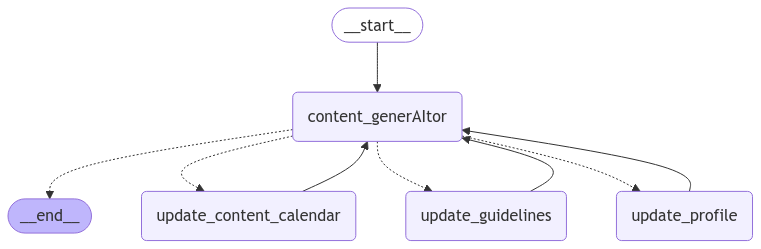

In [ ]:
# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# Testing our AI Agent

In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "Lore"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lore. I live in Ghent. I have 2 cats. I write articles for Medium and create YouTube tutorials mostly targetting developers that want to learn how to build generative AI apps")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Lore. I live in Ghent. I have 2 cats. I write articles for Medium and create YouTube tutorials mostly targetting developers that want to learn how to build generative AI apps
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_SUcNokGT5ag2k9kpqGjxNpwd)
 Call ID: call_SUcNokGT5ag2k9kpqGjxNpwd
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it! If you have any content ideas or need help organizing your content calendar, feel free to let me know.


When examining our Profile schema we can see that the AI Agent has stored the information in the relevant fields.

In [ ]:
# Check for updated instructions
user_id = "Lore"

# Search
for memory in across_thread_memory.search(("profile", user_id)):
    print(memory.value)

{'name': 'Lore', 'location': 'Ghent', 'target_audience': 'developers that want to learn how to build generative AI apps', 'preferred_platforms': ['Medium', 'YouTube']}


Let's now add a piece of content to our content calendar.

In [ ]:
# User input for Content Item
input_messages = [HumanMessage(content="I want to write an article about AI agents to post next Friday.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I want to write an article about AI agents to post next Friday.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_6EDErnmulIptJcsucPSg7FWK)
 Call ID: call_6EDErnmulIptJcsucPSg7FWK
  Args:
    update_type: content_calendar
================================= Tool Message =================================

New ContentCalendar created:
Content: {'title': 'LangGraph AI Agents', 'platform': 'Medium', 'status': 'idea', 'tags': ['AI', 'LangGraph', 'Technology'], 'idea': 'Write an article about LangGraph AI Agents, exploring their features, applications, and potential impact on the industry.'}

Document 0 updated:
Plan: Set the 'deadline' field to the date of Friday next week. This involves calculating the date and updating the 'deadline' field in the ContentCalendar schema.
Added content: 2023-11-10T00:00:00Z

New ContentCalendar created:
Content: {'t

We can see that a new item was added to our content calendar.

In [ ]:
# Check for updated instructions
user_id = "Lore"

# Search
for memory in across_thread_memory.search(("content_calendar", user_id)):
    print(memory)
    print(memory.value)

Item(namespace=['content_calendar', 'Lore'], key='b0cfc12d-ff3c-4b62-ae90-35d001de5f5f', value={'title': 'AI Agents', 'platform': 'Medium', 'deadline': '2024-12-20T00:00:00', 'status': 'idea', 'tags': ['AI', 'agents', 'generative AI'], 'idea': 'An article exploring the concept of AI agents, their applications, and how they can be used in building generative AI apps.'}, created_at='2024-12-13T14:48:11.765441+00:00', updated_at='2024-12-13T14:48:11.765443+00:00', score=None)
{'title': 'AI Agents', 'platform': 'Medium', 'deadline': '2024-12-20T00:00:00', 'status': 'idea', 'tags': ['AI', 'agents', 'generative AI'], 'idea': 'An article exploring the concept of AI agents, their applications, and how they can be used in building generative AI apps.'}


We can now use this AI Agent to list our planned content items.

In [ ]:
# User input for Content Item
input_messages = [HumanMessage(content="can you list all my content for next week?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

can you list all my content for next week?
================================== Ai Message ==================================

Here's what you have scheduled for next week:

1. **Title:** AI Agents
   - **Platform:** Medium
   - **Deadline:** Friday, November 10, 2023
   - **Status:** Idea
   - **Tags:** AI, agents, generative AI
   - **Idea:** An article exploring the concept of AI agents, their applications, and how they can be used in building generative AI apps.

If there's anything else you need or if you want to add more content, feel free to let me know!


Or to help us with drafting pieces of content.

In [ ]:
# User input for Content Item
input_messages = [HumanMessage(content="can you help me with my Medium article for next friday.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

can you help me with my Medium article for next friday.
================================== Ai Message ==================================

Of course! Let's get started on your Medium article about AI agents. Here are a few steps we can take:

1. **Outline the Article:**
   - **Introduction:** Briefly introduce AI agents and their relevance in today's tech landscape.
   - **What are AI Agents?:** Define AI agents and explain their basic functionalities.
   - **Applications in Generative AI:** Discuss how AI agents can be used in building generative AI apps.
   - **Benefits and Challenges:** Highlight the advantages and potential challenges of using AI agents.
   - **Conclusion:** Summarize the key points and discuss future trends or developments.

2. **Research and Gather Information:**
   - Look for recent studies, articles, or case studies about AI agents.
   - Gather examples of successful implementation